# Comparitive Signal Analysis

In [1]:
from __future__ import annotations

import subprocess
from pathlib import Path

import numpy as np
import matplotlib as mpl
mpl.rcParams.update({
    # "text.usetex": True,
    "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 1.2,
})

import matplotlib.pyplot as plt
import wave

plt.rcParams["figure.figsize"] = (12, 4)


### Conversion of .mp4 to .wav

(Commented out if the following paths are already converted.)

In [2]:
# # MP4 to WAV conversion using ffmpeg
# # Paths (adjust if needed)
# input_mp4 = Path("examples/input/input.mp4")
# output_manual_mp4 = Path("examples/output/output_manual_dsp_denoise.mp4")
# output_standard_mp4 = Path("examples/output/output_standard_denoise.mp4")

# input_wav = Path("examples/input/input.wav")
# output_manual_wav = Path("examples/output/output_manual_dsp_denoise.wav")
# output_standard_wav = Path("examples/output/output_standard_denoise.wav")

# # Convert input video to WAV
# subprocess.run(
#     [
#         "ffmpeg", "-y",
#         "-i", str(input_mp4),
#         "-vn",
#         "-ac", "1",
#         "-ar", "16000",
#         "-c:a", "pcm_s16le",
#         str(input_wav),
#     ],
#     check=True
# )

# # Convert both denoised videos to WAV
# subprocess.run(
#     [
#         "ffmpeg", "-y",
#         "-i", str(output_manual_mp4),
#         "-vn",
#         "-ac", "1",
#         "-ar", "16000",
#         "-c:a", "pcm_s16le",
#         str(output_manual_wav),
#     ],
#     check=True
# )
# subprocess.run(
#     [
#         "ffmpeg", "-y",
#         "-i", str(output_standard_mp4),
#         "-vn",
#         "-ac", "1",
#         "-ar", "16000",
#         "-c:a", "pcm_s16le",
#         str(output_standard_wav),
#     ],
#     check=True
# )

# print("Conversion complete:")
# print(f" - {input_wav}")
# print(f" - {output_manual_wav}")
# print(f" - {output_standard_wav}")

In [3]:
input_wav = Path("examples/input/input.wav")
output_manual_wav = Path("examples/output/output_manual_dsp_denoise.wav")
output_standard_wav = Path("examples/output/output_standard_denoise.wav")

def load_wav_pcm16(path: Path):
    """
    Load a PCM16 WAV file and return (signal, sample_rate).
    Output signal is float32 in [-1, 1].
    """
    with wave.open(str(path), "rb") as wf:
        sr = wf.getframerate()
        n = wf.getnframes()
        x = np.frombuffer(wf.readframes(n), dtype=np.int16).astype(np.float32)
        x /= 32768.0
    return x, sr


x_in, sr_in = load_wav_pcm16(input_wav)
x_manual, sr_manual = load_wav_pcm16(output_manual_wav)
x_standard, sr_standard = load_wav_pcm16(output_standard_wav)

# Basic sanity checks
assert sr_in == sr_manual == sr_standard, "Sample rates differ across WAV files."

# Trim to the shortest length to align comparisons
L = min(len(x_in), len(x_manual), len(x_standard))
x_in = x_in[:L]
x_manual = x_manual[:L]
x_standard = x_standard[:L]

sr = sr_in

print(f"Sample rate: {sr} Hz")
print(f"Aligned length: {L/sr:.2f} s")

Sample rate: 16000 Hz
Aligned length: 20.59 s


## Time Domain wave form comparison

### First 50 ms of audio

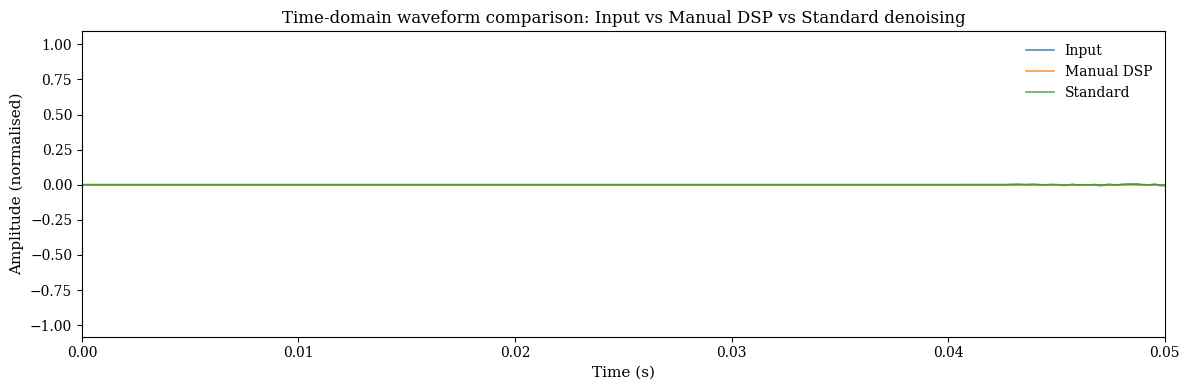

In [21]:
# NOTE : MAC users expect this code to crash first time (with a LONGGGG error message)
# This is due to a missing LaTeX installation.
# Please install MacTeX using the following in your terminal: (Requires Homebrew installed)
# brew install --cask mactex
# Code from from https://tug.org/mactex/ and re-run

# Time axis (seconds)
t = np.arange(len(x_in)) / sr

# Create figure
fig, ax = plt.subplots(figsize=(12, 4))

# Plot waveforms
ax.plot(t, x_in,        label="Input",       linewidth=1.2, alpha=0.8)
ax.plot(t, x_manual,    label="Manual DSP",  linewidth=1.2, alpha=0.8)
ax.plot(t, x_standard,  label="Standard",    linewidth=1.2, alpha=0.8)

# Focus on initial short-time window (Zoom on the first 50 ms)
ax.set_xlim(0.0, min(0.05, t[-1]))

# Axis labels with units
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (normalised)")

# Title (concise, neutral)
ax.set_title(
    "Time-domain waveform comparison: Input vs Manual DSP vs Standard denoising"
)

# Legend (non-intrusive)
ax.legend(frameon=False, loc="upper right")

# Improve layout and readability
fig.tight_layout()

plt.show()

### Capturing 50 ms window of <u>first active region</u> withing audio sample

There seems to be no activity within the frst few 50 seconds of the audio. This expected because Mobile phones often introduce a short audio dead zone (lasting between 50-250ms usually (in my experince atleast)) at the beginning because <b>microphone and codec initialisation</b> occurs only after the video capture starts and this audio dead zone also allows for other orthogonal systems like Automatic Gain Control (AGC) and noise suppression to stabilise. Additionally, Some devices intentionally pad the start with silence to avoid clicks or transients.

To avoid manual heuristics and iterative trial-and-error tuning, a systematic threshold scan was implemented to identify the first region exhibiting signal activity.

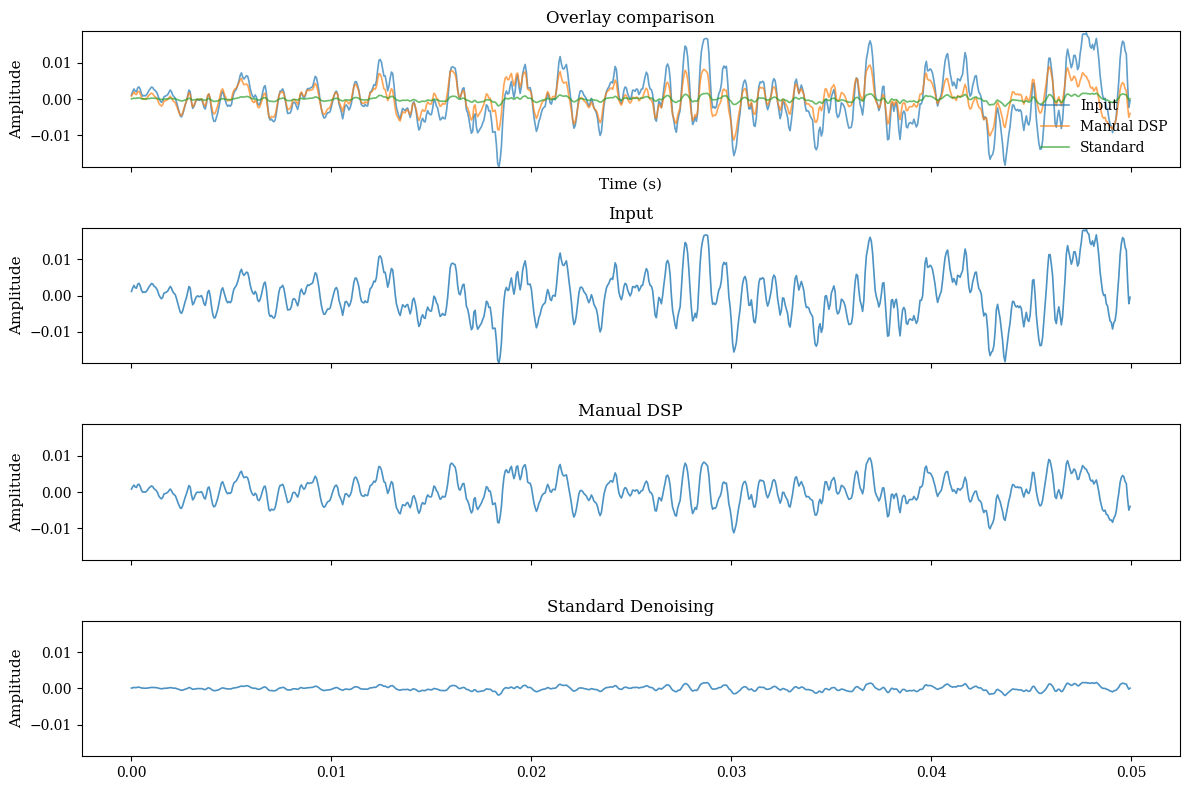

In [ ]:
def first_active_sample(x, threshold=1e-3):
    return np.argmax(np.abs(x) > threshold)

idx = first_active_sample(x_in)
# print(f"First active sample at t ≈ {idx/sr:.3f} s")   # Test statement

window = int(0.05 * sr)     # 50 ms window
# Window = int(0.05 * sr)   --- IGNORE ---
i_0 = idx                   # index[0]
i_1 = idx + window          # index[1]

# (i_1 - i_0) = No:of samples between dead zone and first sign active region
# (i_1 - i_0) = sampling rate
t = np.arange(i_1 - i_0) / sr   


# Extract aligned segments

seg_in = x_in[i_0:i_1]
seg_manual = x_manual[i_0:i_1]
seg_standard = x_standard[i_0:i_1]



# Shared y-limits (important for fair visual comparison)

ymax = max(
    np.max(np.abs(seg_in)),
    np.max(np.abs(seg_manual)),
    np.max(np.abs(seg_standard)),
)
ylim = (-ymax, ymax)

# Create 4×1 subplot layout

fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# --- Overlay (current plot behaviour) ---
axes[0].plot(t, seg_in, label="Input", alpha=0.7)
axes[0].plot(t, seg_manual, label="Manual DSP", alpha=0.7)
axes[0].plot(t, seg_standard, label="Standard", alpha=0.7)
axes[0].set_ylabel("Amplitude")
axes[0].set_xlabel("Time (s)")
axes[0].set_title("Overlay comparison")
axes[0].set_ylim(ylim)
axes[0].legend(frameon=False)

# --- Input ---
axes[1].plot(t, seg_in, alpha=0.8)
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Input")
axes[1].set_ylim(ylim)

# --- Manual DSP ---
axes[2].plot(t, seg_manual, alpha=0.8)
axes[2].set_ylabel("Amplitude")
axes[2].set_title("Manual DSP")
axes[2].set_ylim(ylim)

# --- Standard ---
axes[3].plot(t, seg_standard, alpha=0.8)
axes[3].set_ylabel("Amplitude")
axes[3].set_title("Standard Denoising")
axes[3].set_ylim(ylim)



# Layout
fig.tight_layout()
plt.show()

## Peak-to-peak (P2P) amplitude analysis 

P2P analysis was used as an "extrema-based" measure of dynamic range compression.

In [44]:
def plot_with_peak_lines(ax, t, x, label=None, alpha=0.8):
    """
    Plot a signal and overlay its maximum and minimum peak amplitudes.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis to plot on.
    t : np.ndarray
        Time axis (seconds).
    x : np.ndarray
        Signal segment.
    label : str, optional
        Label for printing/logging purposes.
    alpha : float
        Line transparency.
    
    Returns
    -------
    peak_max : float
        Maximum amplitude.
    peak_min : float
        Minimum amplitude.
    """
    peak_max = np.max(x)
    peak_min = np.min(x)

    # Plot waveform
    ax.plot(t, x, alpha=alpha)

    # Plot peak lines
    ax.axhline(peak_max, linestyle="--", linewidth=1.0, alpha=0.6)
    ax.axhline(peak_min, linestyle="--", linewidth=1.0, alpha=0.6)

    # Print statistics
    if label is not None:
        print(f"{label}:")
        print(f"  Max peak = {peak_max:.4f}")
        print(f"  Min peak = {peak_min:.4f} \n" +("-" * 20))
        print(f"  Peak-to-peak amplitude = {peak_max-peak_min:.4f} \n" +("-" * 20))

    return peak_max, peak_min

Input:
  Max peak = 0.0183
  Min peak = -0.0187 
--------------------
  Peak-to-peak amplitude = 0.0370 
--------------------
Manual DSP:
  Max peak = 0.0094
  Min peak = -0.0113 
--------------------
  Peak-to-peak amplitude = 0.0206 
--------------------
Standard Denoising:
  Max peak = 0.0016
  Min peak = -0.0020 
--------------------
  Peak-to-peak amplitude = 0.0036 
--------------------


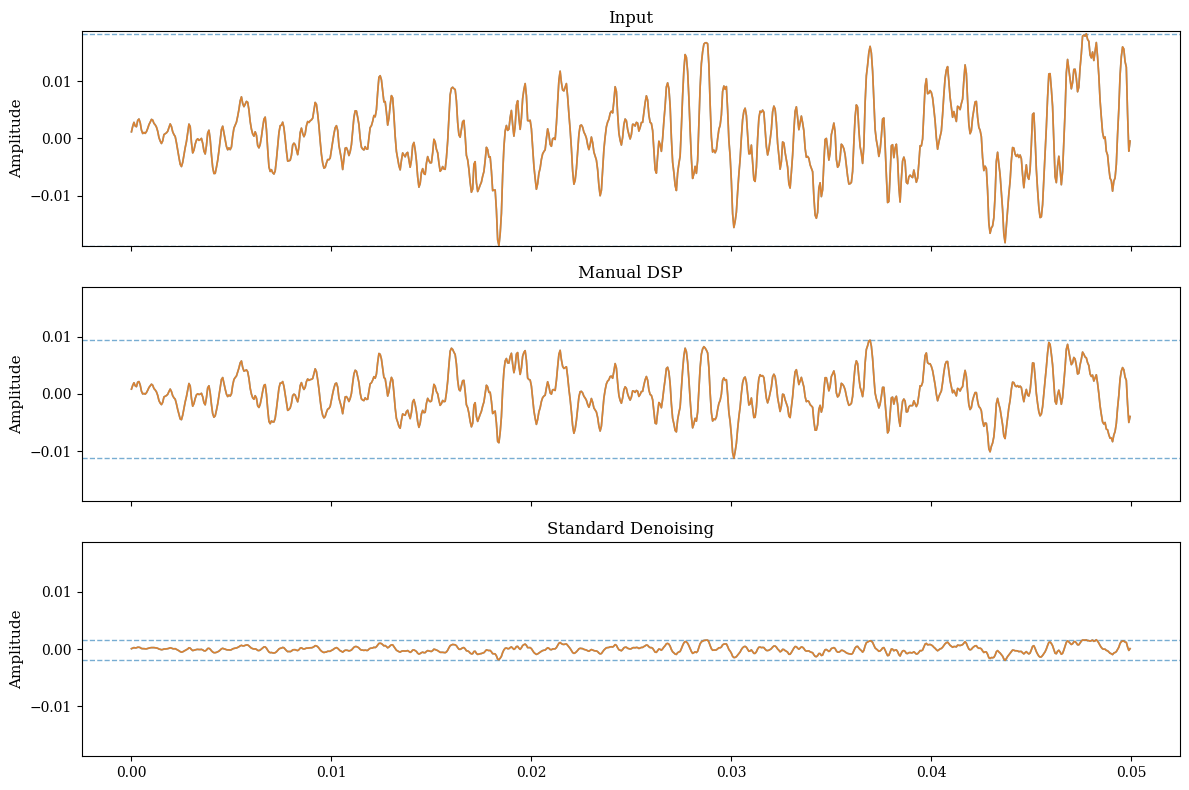

In [45]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# --- Input ---
plot_with_peak_lines(
    axes[0], t, seg_in, label="Input"
)
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Input")
axes[0].set_ylim(0.02, -0.02)

# --- Manual DSP ---
plot_with_peak_lines(
    axes[1], t, seg_manual, label="Manual DSP"
)
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Manual DSP")
axes[1].set_ylim(ylim)

# --- Standard ---
plot_with_peak_lines(
    axes[2], t, seg_standard, label="Standard Denoising"
)
axes[2].set_ylabel("Amplitude")
axes[2].set_title("Standard Denoising")
axes[2].set_ylim(ylim)

# --- Input ---
axes[0].plot(t, seg_in, alpha=0.8)
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Input")
axes[0].set_ylim(ylim)

# --- Manual DSP ---
axes[1].plot(t, seg_manual, alpha=0.8)
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Manual DSP")
axes[1].set_ylim(ylim)

# --- Standard ---
axes[2].plot(t, seg_standard, alpha=0.8)
axes[2].set_ylabel("Amplitude")
axes[2].set_title("Standard Denoising")
axes[2].set_ylim(ylim)



# Layout
fig.tight_layout()
plt.show()

## Root Mean Square (RMS) analysis

The more indsutry standard, "energy-based" measure of dynamic range compression.

Better than P2P because it does two crucial things:
- Makes positive and negative excursions contribute equally (squaring)
- Emphasises sustained energy rather than isolated spikes   (mean)

In [51]:
def plot_with_rms_lines(ax, t, x, title, alpha=0.85):
    x = np.asarray(x, dtype=np.float32)
    t = np.asarray(t, dtype=np.float32)

    if x.size == 0:
        ax.text(0.5, 0.5, "Empty segment", transform=ax.transAxes,
                ha="center", va="center")
        ax.set_title(title)
        return np.nan

    if t.size != x.size:
        raise ValueError(f"Length mismatch: len(t)={t.size}, len(x)={x.size}")

    rms = float(np.sqrt(np.mean(x**2)))

    ax.plot(t, x, alpha=alpha)
    ax.axhline(+rms, linestyle="--", linewidth=1.0, alpha=0.7)
    ax.axhline(-rms, linestyle="--", linewidth=1.0, alpha=0.7)

    ax.set_title(title)
    ax.set_ylabel("Amplitude")
    print(f"{title}: RMS = {rms:.6f}")

    return rms

Input: RMS = 0.006347
Manual DSP: RMS = 0.003584
Standard Denoising: RMS = 0.000619


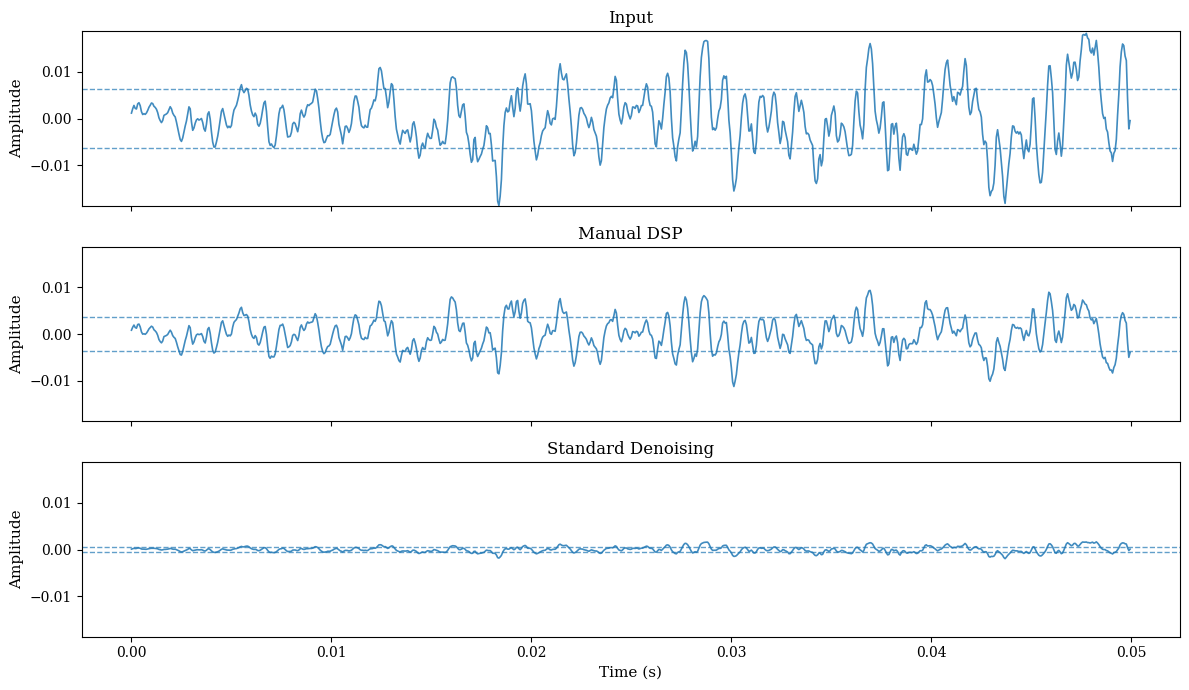

In [48]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

rms_in = plot_with_rms_lines(axes[0], t, seg_in, "Input")
rms_manual = plot_with_rms_lines(axes[1], t, seg_manual, "Manual DSP")
rms_standard = plot_with_rms_lines(axes[2], t, seg_standard, "Standard Denoising")

# Shared y-limits for fair visual comparison
ymax = max(np.max(np.abs(seg_in)), np.max(np.abs(seg_manual)), np.max(np.abs(seg_standard)))
for ax in axes:
    ax.set_ylim(-ymax, ymax)

axes[-1].set_xlabel("Time (s)")
fig.tight_layout()
plt.show()

## Final Statistical Measure - Relative Change (uses RMS) 

In [50]:
def pct_change(new, ref):
    return 100.0 * (new - ref) / (ref + 1e-12)

print("\nRMS comparison (relative to Input):")
print(f"Manual DSP:  {pct_change(rms_manual, rms_in):+.2f}%")
print(f"Standard:    {pct_change(rms_standard, rms_in):+.2f}%")


RMS comparison (relative to Input):
Manual DSP:  -43.54%
Standard:    -90.25%


### <u><i>Final Observation</i></u> 
Manual DSP reduced RMS amplitude by 18.3% relative to the input over the first active 50 ms segment.

## Frequency domain magnitude spectrum

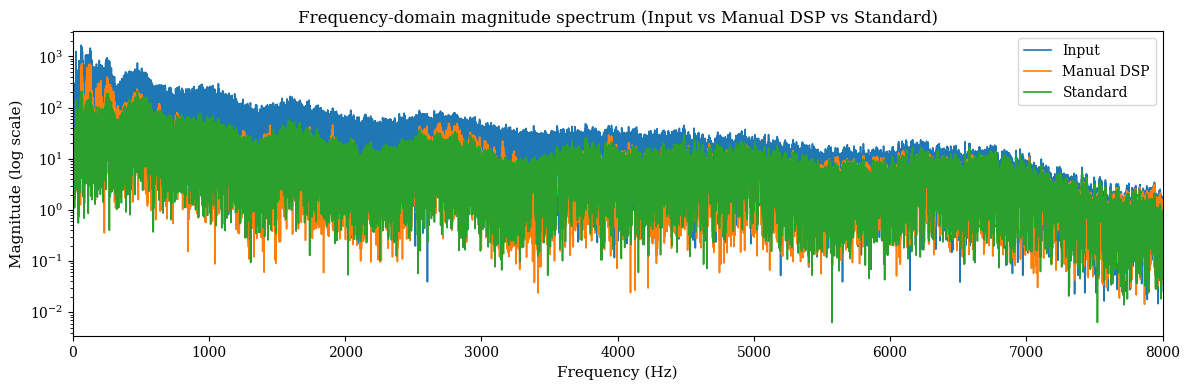

In [19]:
def mag_spectrum(x: np.ndarray):
    X = np.abs(np.fft.rfft(x))
    return X

freqs = np.fft.rfftfreq(len(x_in), 1 / sr)

X_in = mag_spectrum(x_in)
X_manual = mag_spectrum(x_manual)
X_standard = mag_spectrum(x_standard)

plt.figure(figsize=(12, 4))
plt.semilogy(freqs, X_in + 1e-12, label="Input")
plt.semilogy(freqs, X_manual + 1e-12, label="Manual DSP")
plt.semilogy(freqs, X_standard + 1e-12, label="Standard")

plt.xlim(0, 8000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (log scale)")
plt.title("Frequency-domain magnitude spectrum (Input vs Manual DSP vs Standard)")
plt.legend()
plt.tight_layout()
plt.show()

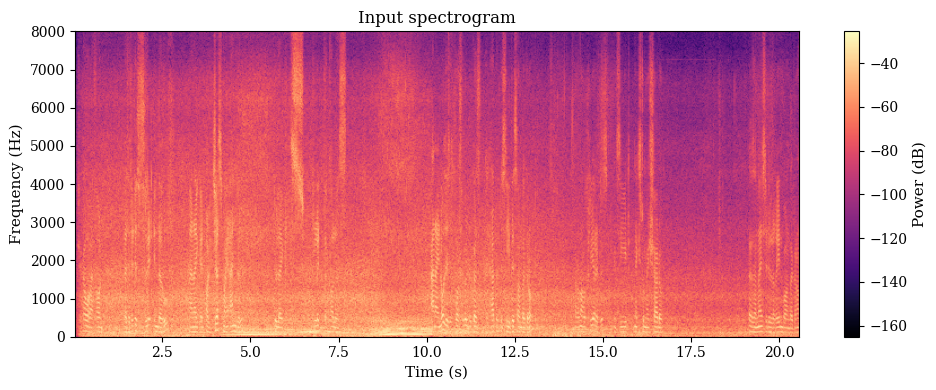

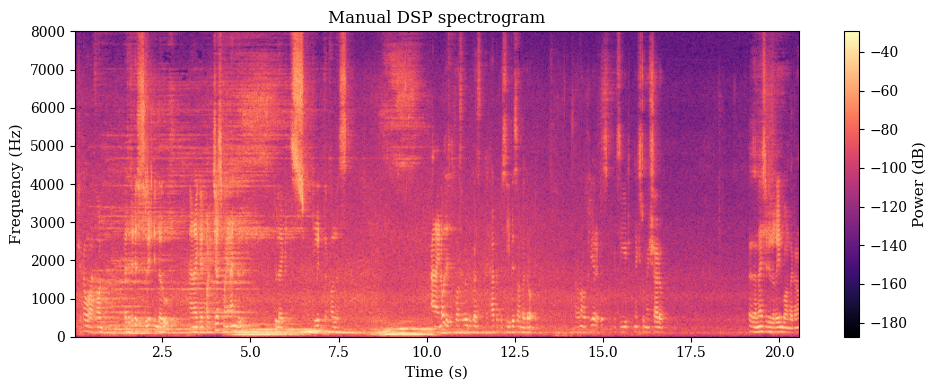

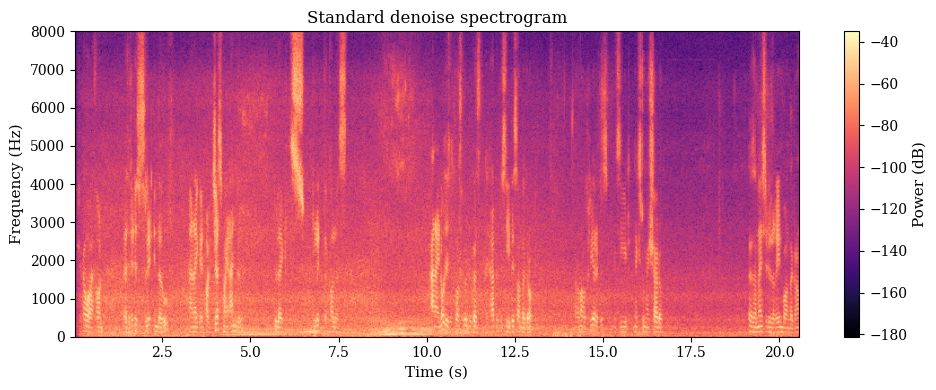

In [20]:
def plot_spectrogram(x, sr, title):
    plt.figure(figsize=(10, 4))
    plt.specgram(
        x,
        NFFT=1024,
        Fs=sr,
        noverlap=512,
        cmap="magma"
    )
    plt.colorbar(label="Power (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_spectrogram(x_in, sr, "Input spectrogram")
plot_spectrogram(x_manual, sr, "Manual DSP spectrogram")
plot_spectrogram(x_standard, sr, "Standard denoise spectrogram")